In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import Input



In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

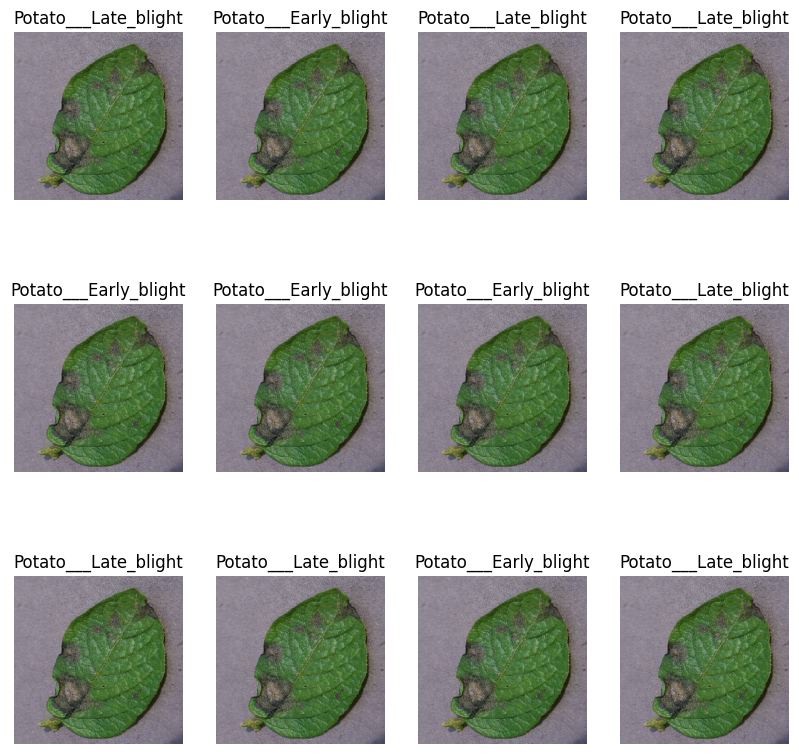

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3, 4, i + 1)
        #print(image_batch[0].numpy())
        #print(labels_batch.numpy())
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        
   

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(int(len(dataset)*train_size))
len(train_ds)

54

In [9]:
dataset.skip(int(len(dataset)*train_size))

<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
test_ds=dataset.skip(int(len(dataset)*train_size))
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)#reshuffle_each_iteration=True)
    train_size = int(len(ds) * train_split)
    val_size = int(len(ds) * val_split)
    test_size = int(len(ds) * test_split)
    
    train_ds =ds.take(train_size)
    test_ds = ds.skip(train_size).skip(val_size)
    val_ds = ds.skip(train_size).take(val_size)
      
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [17]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [19]:
data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    ])

In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32,  (3,3),   activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3),  activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3),  activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3),  activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3),  activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3),  activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

e:\Rakshith\AIML\tfenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
model.fit(
    train_ds,
    batch_size =BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.4707 - loss: 0.9209 - val_accuracy: 0.6562 - val_loss: 0.7334
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.6736 - loss: 0.7000 - val_accuracy: 0.8333 - val_loss: 0.4172
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.7723 - loss: 0.5234 - val_accuracy: 0.9010 - val_loss: 0.2766
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8763 - loss: 0.3235 - val_accuracy: 0.9271 - val_loss: 0.2086
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8693 - loss: 0.2849 - val_accuracy: 0.9323 - val_loss: 0.2323
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8960 - loss: 0.2603 - val_accuracy: 0.9375 - val_loss: 0.1470
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.8887 - loss: 0.2695 - val_accuracy: 0.9010 - val_loss: 0.2891
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8974 - loss: 0.2559 - val_accuracy: 0.9167 - v

In [26]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 740ms/step - accuracy: 0.9817 - loss: 0.0846


In [27]:
scores

[0.08690425008535385, 0.98046875]

In [30]:
model.save("potato_disease_model.h5")

In [32]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']    

NameError: name 'plot' is not defined

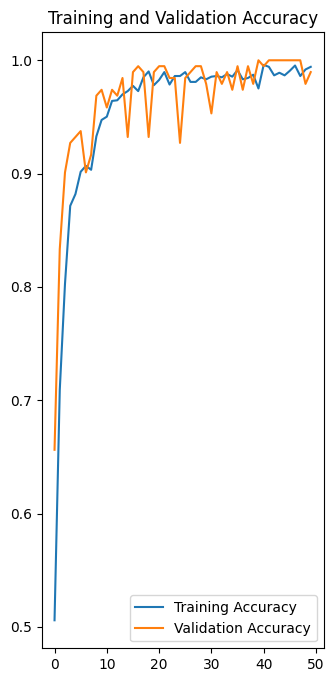

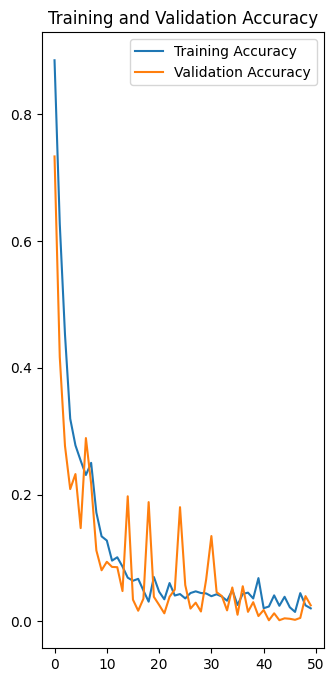

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')   
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')  
plot.show()


first image to predict
first image's actual label is:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
predicted label: Potato___Early_blight


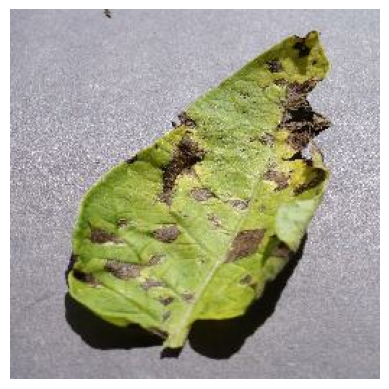

In [53]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label is: ", class_names[first_label])
    plt.axis("off")
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])    

In [54]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


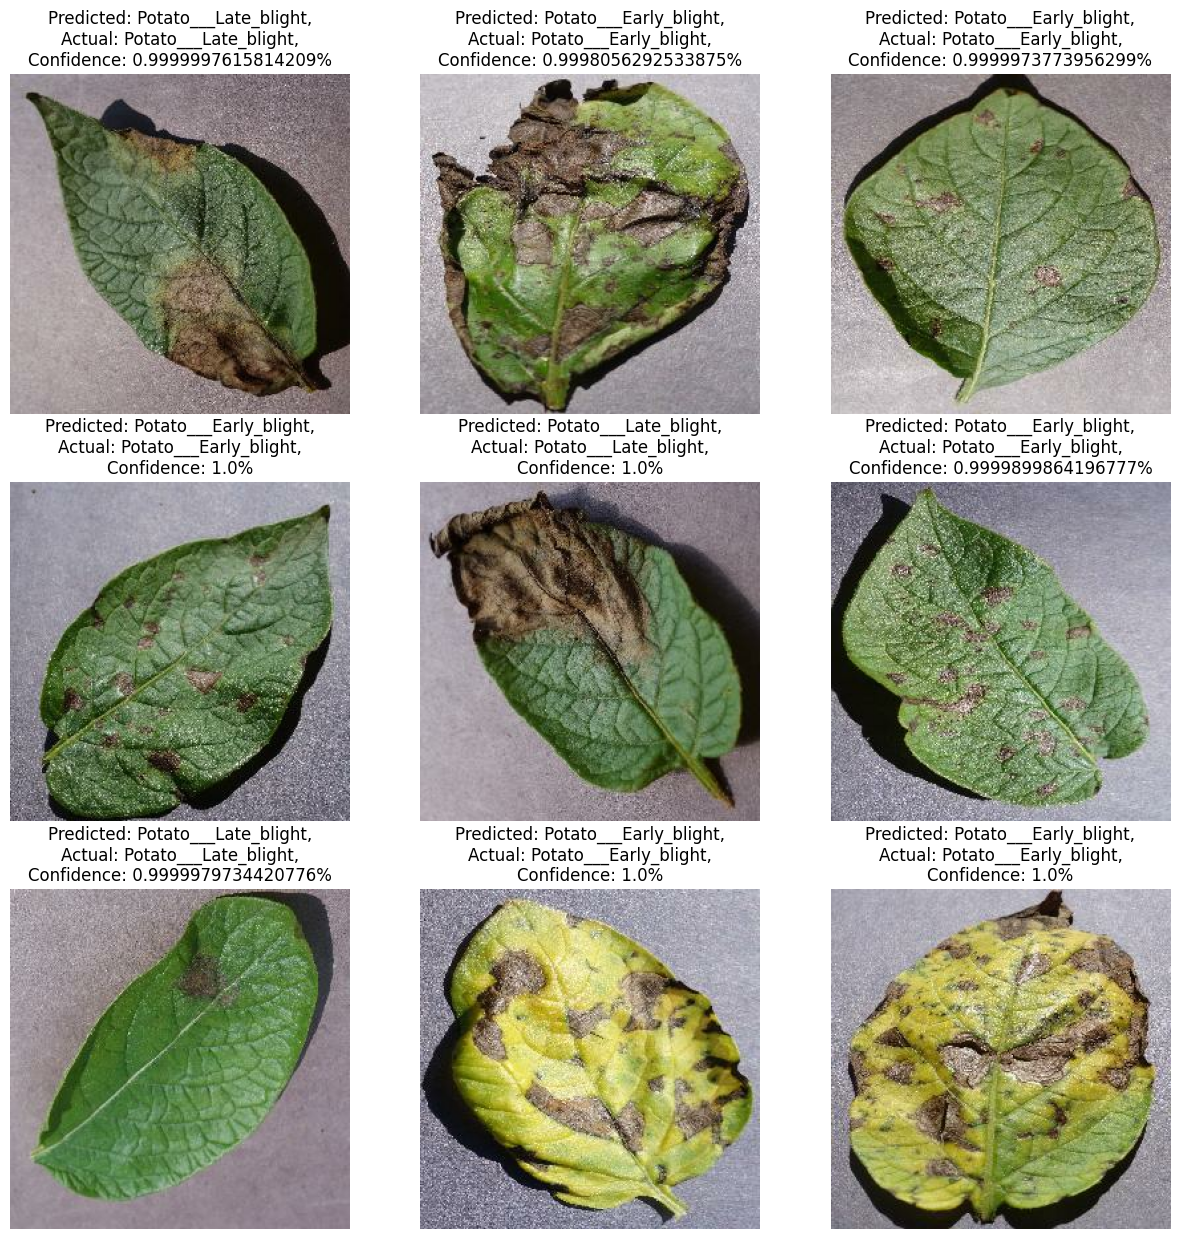

In [63]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Predicted: {predicted_class},\nActual: {actual_class},\nConfidence: {confidence}%")
        plt.axis("off")

    

In [64]:
model_version = 1
model.save(f"models/potato_disease_model_v{model_version}.h5")